In [44]:
import torch
import math
import numpy as np
import functools
import operator
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

In [45]:
batch_size_train = 64
batch_size_test = 1000


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [46]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

In [47]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [48]:
network = ConvNet()
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [49]:
def train_step(output, target):
    optimizer.zero_grad()
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    return loss

In [50]:
log_interval = 10
epochs = 3
running_loss = 0.0
running_corrects = 0.0
val_running_loss = 0.0
val_running_corrects = 0.0

train_losses = []
train_acc = []

In [51]:
for epoch in range(1, epochs+1):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        output = network(data)
        loss = train_step(output, target)
        train_losses.append(loss.item())
        _, preds = torch.max(output, 1)
        running_corrects = (preds== target).sum().item() / preds.size(0)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), 
                running_corrects))
        train_acc.append(running_corrects)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.523531 Acc: 0.062500
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.490056 Acc: 0.515625
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.925778 Acc: 0.703125
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.744870 Acc: 0.750000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.503368 Acc: 0.906250
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.607768 Acc: 0.875000
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.679876 Acc: 0.796875
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.683373 Acc: 0.812500
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.314133 Acc: 0.906250
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.305863 Acc: 0.890625
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.361668 Acc: 0.937500
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.336769 Acc: 0.906250
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.437873 Acc: 0.906250
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.290907 Acc: 0.906250
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.471857 Acc: 0.906250
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.302474 Acc: 0.875000
Train

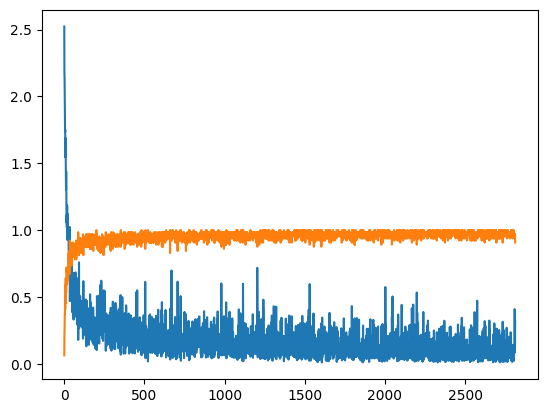

In [52]:
import matplotlib.pyplot as plt
plt.plot(train_losses)